In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.43G/6.43G [01:28<00:00, 78.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3


In [ ]:
import os

# Root path from kagglehub
path = "/root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3"


train_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "train")
test_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "test")

print("Train path:", train_dir)
print("Test path:", test_dir)


print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))


Train path: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train
Test path: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test
Train subfolders: ['fire', 'Smoke', 'non fire']
Test subfolders: ['fire', 'Smoke', 'non fire']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np


np.random.seed(42)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


train_subset_size = 10000
train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
train_subset = Subset(train_dataset, train_indices)


test_subset_size = 2000
test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)
test_subset = Subset(test_dataset, test_indices)


train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


print("Classes:", train_dataset.classes)
print("Train subset size:", len(train_subset))
print("Test subset size:", len(test_subset))


Classes: ['Smoke', 'fire', 'non fire']
Train subset size: 10000
Test subset size: 2000


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Acc: {train_acc:.2f}%")



Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Epoch [1/3] Loss: 0.2074 Acc: 93.27%
Epoch [2/3] Loss: 0.1436 Acc: 95.52%
Epoch [3/3] Loss: 0.1122 Acc: 96.50%


In [ ]:
save_path = "/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth"
torch.save(model.state_dict(), save_path)
print(f" Model saved at {save_path}")


 Model saved at /content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth"))


NameError: name 'model' is not defined

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18(weights=None)  # pretrained=None since we only load your trained weights
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully")


Model loaded successfully



=== Test Set Evaluation ===
Accuracy : 0.9590
Precision: 0.9608
Recall   : 0.9586
F1-score : 0.9592

=== Classification Report ===
              precision    recall  f1-score   support

       Smoke       0.92      0.98      0.95       683
        fire       0.99      0.95      0.97       683
    non fire       0.97      0.94      0.96       634

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



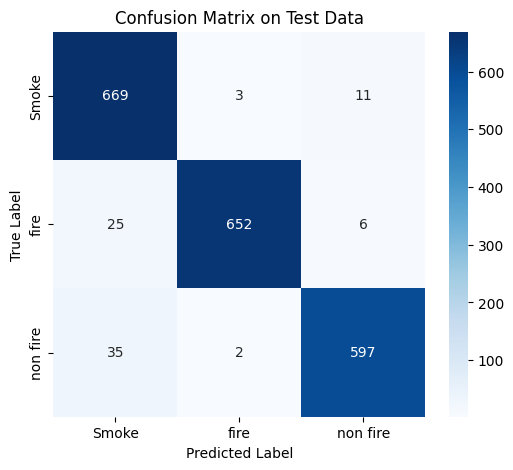

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Put model in evaluation mode
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n=== Test Set Evaluation ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Classification report with class names
classes = train_dataset.classes
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()
